# AI model for predicting the electricity prices

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from LSTMmodel import *
%load_ext autoreload
%autoreload 2



## Loading the data

In [2]:
# Set random seed for reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

In [3]:
# path to the CSV file
path = '../../data/fulldata.csv'

data = pd.read_csv(path)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,to,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,...,wind_speed_Syddjurs,wind_speed_Sønderborg,wind_speed_Thisted,wind_speed_Tønder,wind_speed_Varde,wind_speed_Vejen,wind_speed_Vejle,wind_speed_Vesthimmerlands,wind_speed_Viborg,wind_speed_Ærø
0,291.329987,2024-10-20 05:00:00+00:00,2024-10-20 06:00:00+00:00,12.3,11.9,11.9,12.2,12.4,11.7,12.4,...,3.0,3.2,6.4,3.8,4.7,3.7,3.5,5.1,4.2,3.9
1,240.389999,2024-10-20 04:00:00+00:00,2024-10-20 05:00:00+00:00,12.4,11.7,11.9,12.4,12.4,11.4,12.4,...,3.1,3.9,5.9,4.0,5.4,3.5,3.3,4.6,4.0,4.1
2,241.880005,2024-10-20 03:00:00+00:00,2024-10-20 04:00:00+00:00,12.5,11.4,11.9,12.5,12.3,11.3,12.4,...,3.2,3.3,5.8,4.2,5.6,3.4,3.2,4.7,4.2,4.5
3,444.450012,2024-10-20 02:00:00+00:00,2024-10-20 03:00:00+00:00,12.4,11.4,11.6,12.5,12.0,11.5,12.4,...,2.5,3.3,5.7,4.2,5.2,3.4,3.2,4.8,4.0,4.4
4,417.000000,2024-10-20 01:00:00+00:00,2024-10-20 02:00:00+00:00,12.4,11.8,11.2,12.4,11.7,12.1,12.3,...,2.1,3.6,5.5,4.0,5.0,3.5,3.2,3.7,3.2,3.7


(120991, 471)


In [ ]:
data['from'] = pd.to_datetime(data['from'])

# drop to column
data = data.drop(columns=['to'])

# get old prices 
lag_hours = [0, -1,# -2, -3, -4, -5, -6, -24, -48, -72, -96, -120, -144, -168
             ]
for lag in lag_hours:
    data[f'price_lag_{lag}'] = data['SpotPriceDKK'].shift(lag)

# offset price by 1 day
data['SpotPriceDKK'] = data['SpotPriceDKK'].shift(24)
# drop the first 24 rows
data = data.dropna()

# offset the from date by 1 day to match the price
data['from'] = data['from'] + pd.DateOffset(days=1)

# extract time features
data['hour'] = data['from'].dt.hour
data['day_of_week'] = data['from'].dt.dayofweek
data['month'] = data['from'].dt.month

# cyclical encoding for hour, day, and month
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,temp_Faaborg-Midtfyn,...,price_lag_-168,hour,day_of_week,month,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
24,291.329987,2024-10-20 05:00:00+00:00,11.5,11.4,10.5,10.7,11.1,11.6,11.4,10.6,...,400.149994,5,6,10,0.965926,0.258819,-0.781831,0.62349,-0.866025,0.5
25,240.389999,2024-10-20 04:00:00+00:00,11.4,11.3,10.7,10.8,11.0,11.5,11.4,10.6,...,534.460022,4,6,10,0.866025,0.500000,-0.781831,0.62349,-0.866025,0.5
26,241.880005,2024-10-20 03:00:00+00:00,11.6,11.2,10.8,11.0,11.2,11.3,11.6,10.9,...,506.619995,3,6,10,0.707107,0.707107,-0.781831,0.62349,-0.866025,0.5
27,444.450012,2024-10-20 02:00:00+00:00,11.7,11.5,10.7,11.3,11.2,11.6,11.6,11.3,...,536.619995,2,6,10,0.500000,0.866025,-0.781831,0.62349,-0.866025,0.5
28,417.000000,2024-10-20 01:00:00+00:00,11.8,12.0,10.6,11.5,11.3,12.0,11.5,11.4,...,559.750000,1,6,10,0.258819,0.965926,-0.781831,0.62349,-0.866025,0.5


(120799, 493)


In [5]:
# extract column names
cols = data.columns.tolist()

# select features and target variable
all_features = cols[2:]
target = cols[:1]

print(f'Count of features before interaction terms: {len(all_features)}')
print(f'Target variable: {target}')

Count of features before interaction terms: 491
Target variable: ['SpotPriceDKK']


In [6]:
# training data: until July 2023
train_data = data[data['from'] < '2023-07-01']

# validation data: July 2023 to December 2023
val_data = data[(data['from'] >= '2023-07-01') & (data['from'] < '2024-01-01')]

# Test data: 2024 and beyond
test_data = data[data['from'] >= '2024-01-01']

X_train = train_data[all_features].values
X_val = val_data[all_features].values
X_test = test_data[all_features].values

In [7]:
# # unfortunately the takes to much memory to process on my machine
# # Initialize PolynomialFeatures
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# # Fit and transform training features
# X_train = poly.fit_transform(X_train)

# # Transform test features
# X_test = poly.transform(X_test)

In [8]:
# initialize the scaler
scaler = StandardScaler()

# fit the scaler on the training features and transform
train_features_scaled = scaler.fit_transform(X_train)

# transform the validation and test features using the same scaler
val_features_scaled = scaler.transform(X_val)
test_features_scaled = scaler.transform(X_test)


In [9]:
# extract target values
train_targets = train_data[target].values
val_targets = val_data[target].values
test_targets = test_data[target].values

In [ ]:
# create data class
class ElectricityDataset(Dataset):
    def __init__(self, features, targets, seq_length=24):
        self.features = features
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.targets) - self.seq_length

    def __getitem__(self, idx):
        X = self.features[idx:idx+self.seq_length]
        y = self.targets[idx+self.seq_length]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# define neural network
class PricePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PricePredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden and cell states
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        # LSTM output
        out, _ = self.lstm(x, (h0, c0))

        # get output of the last time step
        out = self.fc(out[:, -1, :])
        return out


# define function for L1 regularization
def l1_regularization(model, lambda_l1):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

In [11]:
# hyperparameters
seq_length = 48  # Use past 48 hours to form a sequence
batch_size = 128 
input_dim = train_features_scaled.shape[1]
hidden_dim = 128
layer_dim = 2
output_dim = 1

In [12]:
# Create datasets
train_dataset = ElectricityDataset(train_features_scaled, train_targets, seq_length)
val_dataset = ElectricityDataset(val_features_scaled, val_targets, seq_length)
test_dataset = ElectricityDataset(test_features_scaled, test_targets, seq_length)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# initialize the model
model = PricePredictor(input_dim, hidden_dim, layer_dim, output_dim)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# L1 regularization parameter
lambda_l1 = 0.01 #1e-5  # Adjust based on desired regularization strength

In [13]:
# training the model
num_epochs = 50
patience = 5  # For early stopping
best_loss = np.inf
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # L1 regularization
        l1_loss = l1_regularization(model, lambda_l1)

        # Total loss
        loss = mse_loss + l1_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average training loss
    avg_epoch_loss = epoch_loss / len(train_loader)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
            l1_loss = l1_regularization(model, lambda_l1)
            loss = mse_loss + l1_loss
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break



Epoch [1/35], Training Loss: 410773.0687, Validation Loss: 341709.9705
Epoch [2/35], Training Loss: 351229.7951, Validation Loss: 269903.1375
Epoch [3/35], Training Loss: 315329.9733, Validation Loss: 221545.5427
Epoch [4/35], Training Loss: 292332.3701, Validation Loss: 181093.3814
Epoch [5/35], Training Loss: 261919.0579, Validation Loss: 138418.3676
Epoch [6/35], Training Loss: 236961.2538, Validation Loss: 98176.1065
Epoch [7/35], Training Loss: 213749.9387, Validation Loss: 65242.8005
Epoch [8/35], Training Loss: 193415.7864, Validation Loss: 45697.6152
Epoch [9/35], Training Loss: 175776.6277, Validation Loss: 34278.8316
Epoch [10/35], Training Loss: 160055.6506, Validation Loss: 25892.8177
Epoch [11/35], Training Loss: 145863.7569, Validation Loss: 21528.7849
Epoch [12/35], Training Loss: 133067.1274, Validation Loss: 17657.0278
Epoch [13/35], Training Loss: 121436.8445, Validation Loss: 14978.0633
Epoch [14/35], Training Loss: 111027.4321, Validation Loss: 13451.5608
Epoch [15/

In [14]:
# Load the best model
model.load_state_dict(torch.load('output/best_model.pth'))

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(y_batch.tolist())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Performance on Test Data (2024):\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR^2 Score: {r2:.4f}')



Performance on Test Data (2024):
RMSE: 34.3488
MAE: 20.0931
R^2 Score: 0.9862


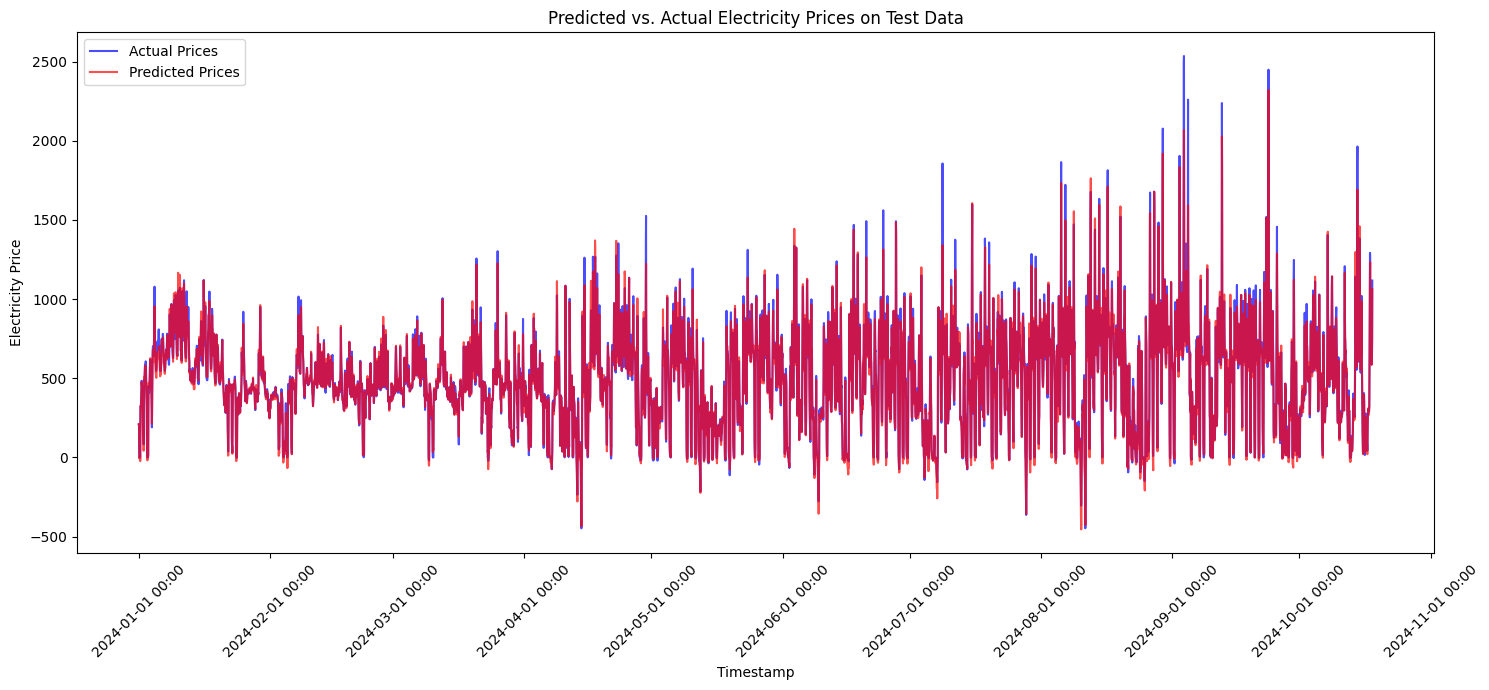

In [15]:
# Convert 'predictions' and 'actuals' to numpy arrays if they aren't already
predictions = np.array(predictions)
actuals = np.array(actuals)

# Extract 'from' timestamps from test_data, adjusted for seq_length
# Since the dataset uses sequences, the first 'seq_length' targets are not included in 'actuals' and 'predictions'
test_timestamps = test_data['from'].values[seq_length:]

# Ensure lengths match
min_length = min(len(test_timestamps), len(actuals), len(predictions))
test_timestamps = test_timestamps[:min_length]
actuals = actuals[:min_length]
predictions = predictions[:min_length]

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actuals, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps, predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices on Test Data')

# Format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/predicted_vs_actual_prices2024.png')

plt.show()

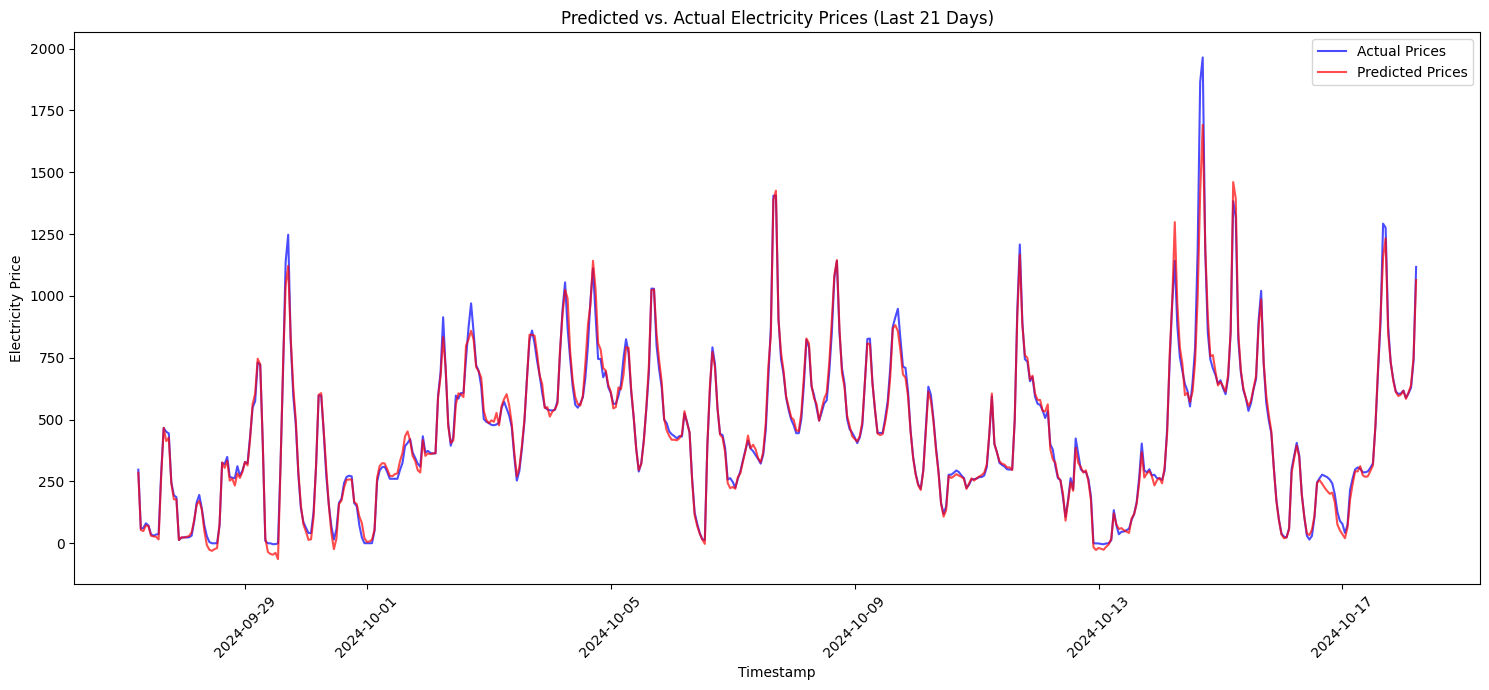

In [16]:
# Plot the first 500 data points
datapoints = 24*21
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps[:datapoints], actuals[:datapoints], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps[:datapoints], predictions[:datapoints], label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title(f'Predicted vs. Actual Electricity Prices (Last {datapoints//24} Days)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f'output/predicted_vs_actual_prices_last{datapoints//24}days.png')
plt.show()


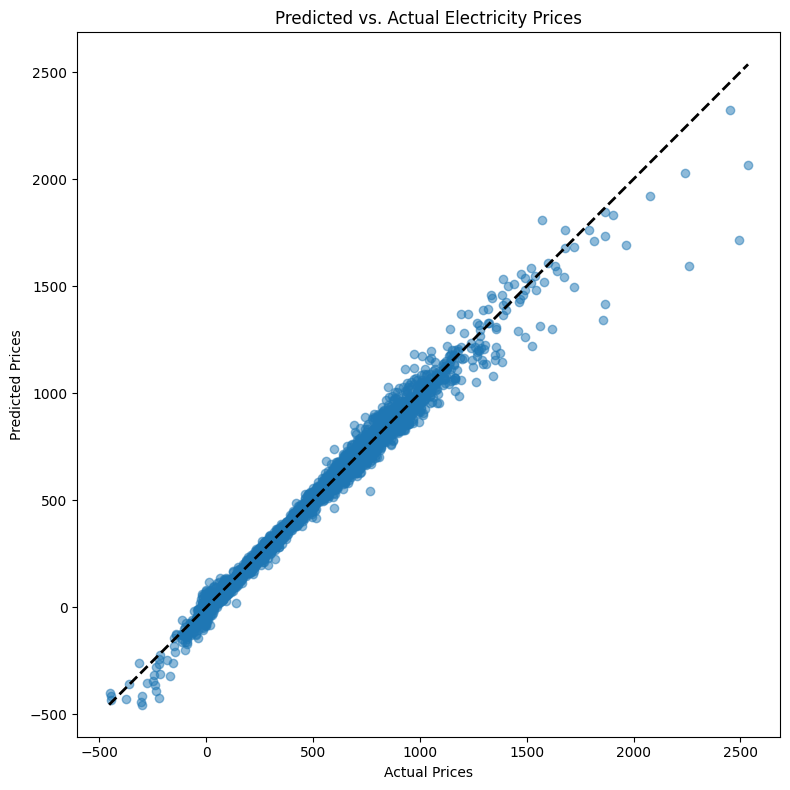

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Electricity Prices')

# Plot a diagonal line for reference
min_price = min(actuals.min(), predictions.min())
max_price = max(actuals.max(), predictions.max())
plt.plot([min_price, max_price], [min_price, max_price], 'k--', lw=2)
plt.tight_layout()

plt.savefig('output/predicted_vs_actual_prices_scatter.png')
plt.show()

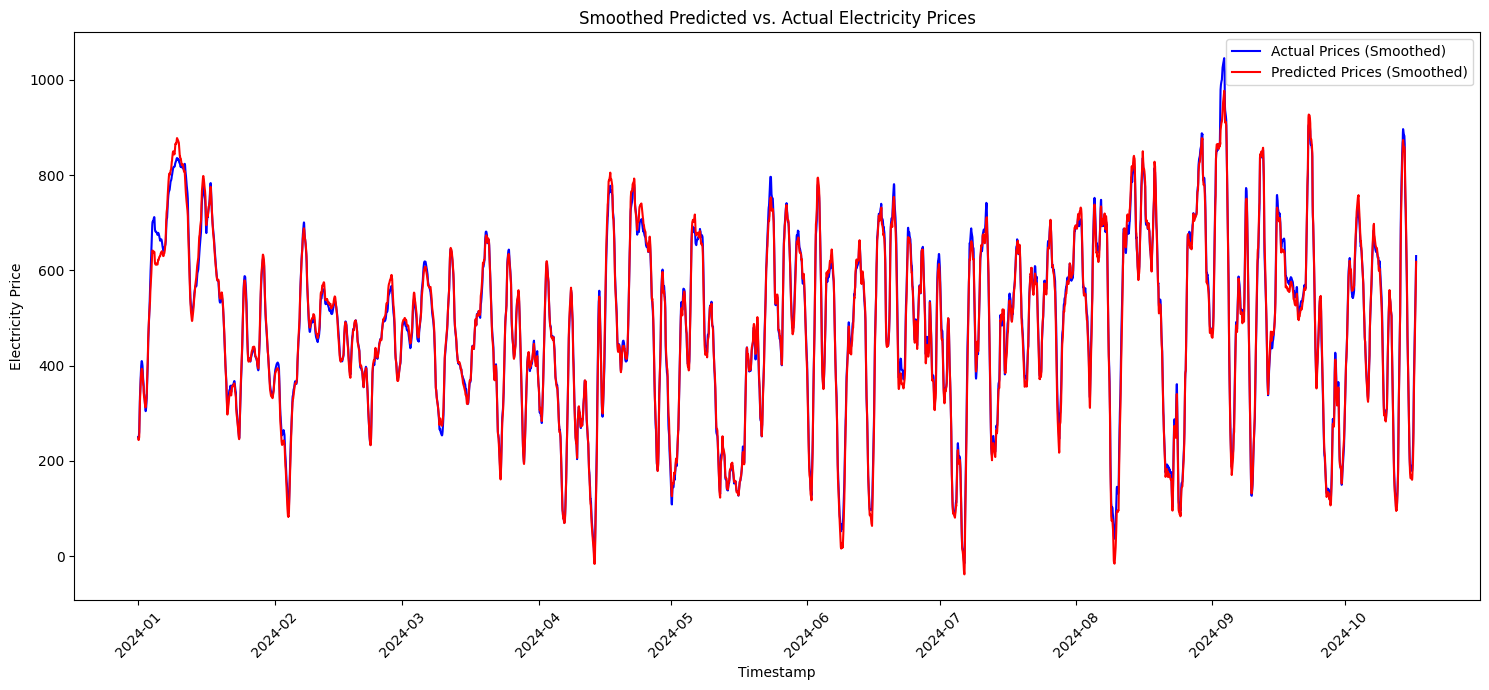

In [18]:
window_size = 24  # e.g., 24 hours
actuals_smooth = pd.Series(actuals.squeeze()).rolling(window=window_size).mean()
predictions_smooth = pd.Series(predictions.squeeze()).rolling(window=window_size).mean()

plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actuals_smooth, label='Actual Prices (Smoothed)', color='blue')
plt.plot(test_timestamps, predictions_smooth, label='Predicted Prices (Smoothed)', color='red')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Smoothed Predicted vs. Actual Electricity Prices')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/predicted_vs_actual_prices_smoothed.png')
plt.show()
